# 0. Libraries import

We start by importing common needed libraries

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import shap
import matplotlib.pyplot as plt
import pickle

We than need to specify the folder in which the CellHit library is currently located and import needed functions from there

In [2]:
library_path = Path('/home/fcarli/CellHit/') #set the path to the library
sys.path.append(library_path) #add the library to the system path
from CellHit.data import prepare_data
from CellHit.data.metadata_processing import obtain_metadata,obtain_drugs_metadata #import the DatasetLoader and prepare_data functions
from CellHit.search_and_inference import search, inference #import the search and inference functions
from CellHit.models.model import EnsembleXGBoost

# 1. Data loading

Then we have to provide the path that contains all of the intermediate inputs needed to run the pipeline (transcriptomics, metadata, pathways, ...)

In [3]:
#specify the data_path
data_path = library_path/'data'

We now specify the dataset wrt which we like to perform the training procedure

In [4]:
#specify the dataset you want to use (possibilities are 'gdsc' or 'prism')
dataset = 'gdsc'

Once we specified all of these informations we can explore both drugs and cell-drug pairs metadata

In [5]:
#in order to check which drugs are available we can leverage the dedicated functions in the library
metadata = obtain_metadata(dataset=dataset,path=data_path)
drugs_metadata = obtain_drugs_metadata(dataset=dataset,path=data_path)

The target is specified in the Y column of the metedata folder. Recall that for the GDSC dataset Y is specified as ln(IC50) whereas for PRISM is a log-fold change

In [6]:
metadata.head()

,COSMICID,DrugID,Drug,Y,DepMapID,OncotreeCode,OncotreeSubtype,OncotreePrimaryDisease,OncotreeLineage
0,683667,1003,Camptothecin,-1.462148,ACH-001711,PNET,Primitive Neuroectodermal Tumor,Embryonal Tumor,CNS/Brain
1,684052,1003,Camptothecin,-4.869447,ACH-000052,ES,Ewing Sarcoma,Ewing Sarcoma,Bone
2,684057,1003,Camptothecin,-3.360684,ACH-002106,ES,Ewing Sarcoma,Ewing Sarcoma,Bone
3,684059,1003,Camptothecin,-5.045014,ACH-002108,ES,Ewing Sarcoma,Ewing Sarcoma,Bone
4,684062,1003,Camptothecin,-3.741620,ACH-002111,ES,Ewing Sarcoma,Ewing Sarcoma,Bone


We can now inspect given metadata for the drugs

In [7]:
drugs_metadata.head()

,DrugID,Drug,PUTATIVE_TARGET,MOA,DRUG_SYNONYMS,SMILES,repurposing_target
0,1003,Camptothecin,TOP1,DNA replication,"Camptothecine, (+)-Camptothecin",CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...,TOP1
1,1004,Vinblastine,Microtubule destabiliser,Mitosis,Velban,CC[C@@]1(C[C@H]2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC...,TUBB
2,1005,Cisplatin,DNA crosslinker,DNA replication,"cis-Diammineplatinum(II) dichloride, Platinol,...",N.N.Cl[Pt]Cl,DNA
3,1006,Cytarabine,Antimetabolite,Other,"Ara-Cytidine, Arabinosyl Cytosine, U-19920",C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...,DNA synthesis
4,1007,Docetaxel,Microtubule stabiliser,Mitosis,"RP-56976, Taxotere",CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,TUBB


We can then set parameters that will identify the drug that we want to model. The function identifies specific drugs using internal drug ids (in the case of GDSC we use their internal drugs ids). In order to lookup a specific drug we suggest to lookup for the needed drug id in `drugs_metadata`

In [8]:
#set data parameters
drugID = 1909
random_state = 0
gene_selection_mode = 'moa_primed' #can be 'all_genes' or 'moa_primed'
use_external_datasets = False
celligner_output_path = data_path/'transcriptomics/celligner_CCLE_TCGA.feather' #path points to the alligned transcriptomics data (using Celligner)
use_dumped_loaders = False #optional to speed up the computations

In [9]:
#obtain the data
data_dict = prepare_data(drugID, dataset, random_state, 
                    gene_selection_mode, 
                    use_external_datasets=use_external_datasets,
                    data_path=data_path,celligner_output_path=celligner_output_path,
                    use_dumped_loaders=use_dumped_loaders)

As the name suggests `data_dict` is a dictionary containing all of the data needed to train the MOA primed model (formatted in the required way). We can however inspect its keys in order to understand better what we have

In [10]:
data_dict.keys()

dict_keys(['cv_data', 'genes', 'loader', 'test_X', 'test_Y', 'test_indexes'])

Note that the `preapare_data` function takes care of fetching the genes specific to the drug of interest 

In [11]:
print(len(data_dict['genes']))
print(data_dict['genes'][0:5])

3769
['ESR1', 'EP400', 'SULT1A4', 'EDEM1', 'GSS']


# 2. Model training

We can than take advantage of the `search` function contained in the CellHit library to perform hyperparameter optimization of the proposed model

In [12]:
#set model parameters
n_trials = 5
n_startup_trials = 1
cv_iterations = 3
num_parallel_tree = 5
gpuID = 0

#launch the hyperparameter search procedure
best_params, study = search(n_trials=n_trials, n_startup_trials=n_startup_trials,
                                cv_iterations=cv_iterations, num_parallel_tree=num_parallel_tree, gpuID=gpuID, random_state=random_state,
                                **data_dict)

``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2024-08-30 15:22:16,424] A new study created in memory with name: no-name-f3b3d3b7-1bc9-4fdb-a624-50c6093d8874
set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
[I 2024-08-30 15:22:28,460] Trial 0 finished with values: {'MSE': 0.4248423228085889, 'Corr': 0.6870134527558927} and parameters: {'eta': 0.5533253688880515, 'learning_rate': 0.2148416205453534, 'n_estimators': 1153, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.8229470565333281, 'colsample_bytree': 0.7187936056313462, 'gamma': 0.8917730007820798, 'early_stopping_rounds': 97, 'lambda': 1.4586037970644443, 'sampling_method': 'uniform'}. 
[I 2024-08-30 15:22:41,670] Trial 1 finished with values: {'MSE': 0.41112594313751777, 'Corr': 0.6976193853319161} and parameters: {'eta': 0.37424547426203003, 'learning_rate': 0.23458129792653187, 'n_estimators': 1249, 'max_depth': 6, 'min_child

Once finished we can acces the set of parameters with the highest correlation score as follows

In [13]:
best_params

{'eta': 0.3894092693433491,
 'learning_rate': 0.1577653481287704,
 'n_estimators': 1098,
 'max_depth': 6,
 'min_child_weight': 5,
 'subsample': 0.6232729888616473,
 'colsample_bytree': 0.7619750884177012,
 'gamma': 0.636408498594761,
 'early_stopping_rounds': 57,
 'lambda': 1.0894611728868169,
 'sampling_method': 'uniform',
 'device': 'cuda:0',
 'tree_method': 'hist',
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'num_parallel_tree': 5}

If one is interested in the full study hyperparameters those can be found by callling

In [14]:
study.trials_dataframe()

,number,values_Corr,values_MSE,datetime_start,datetime_complete,duration,params_colsample_bytree,params_early_stopping_rounds,params_eta,params_gamma,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_sampling_method,params_subsample,state
0,0,0.687013,0.424842,2024-08-30 15:22:16.425535,2024-08-30 15:22:28.459853,0 days 00:00:12.034318,0.718794,97,0.553325,0.891773,1.458604,0.214842,11,5,1153,uniform,0.822947,COMPLETE
1,1,0.697619,0.411126,2024-08-30 15:22:28.461258,2024-08-30 15:22:41.670633,0 days 00:00:13.209375,0.736880,100,0.374245,0.829915,1.421486,0.234581,6,3,1249,uniform,0.588082,COMPLETE
2,2,0.710935,0.399843,2024-08-30 15:22:41.671797,2024-08-30 15:22:52.623181,0 days 00:00:10.951384,0.761975,57,0.389409,0.636408,1.089461,0.157765,6,5,1098,uniform,0.623273,COMPLETE
3,3,0.698440,0.414790,2024-08-30 15:22:52.624233,2024-08-30 15:23:02.991872,0 days 00:00:10.367639,0.709479,56,0.137635,0.457694,0.687138,0.125569,8,5,1225,gradient_based,0.674532,COMPLETE
4,4,0.703143,0.407318,2024-08-30 15:23:02.993571,2024-08-30 15:23:12.334047,0 days 00:00:09.340476,0.782665,43,0.232049,0.454028,1.844750,0.146017,5,5,1198,uniform,0.615059,COMPLETE


# 2b. Load pre-trained models

Alternatively, one can load pre-trained models already trained by us

In [15]:
#drugID = 1909
#pretrained_path = Path(f'/home/fcarli/CellHit/results/gdsc/search_and_inference/moa_primed/pretrained_GDSC/{drugID}/')
#pretrained_model = EnsembleXGBoost.load_model(pretrained_path)

# 3. Inference on internal data (cell lines)

The inference on the internal data then can be called by simply leveraging the `inference` function 

In [16]:
inference_results = inference(
        model= pretrained_model if 'pretrained_model' in locals() else None, #load only if pretrained model is available
        best_params=best_params, 
        refit=False if 'pretrained_model' in locals() else True,
        internal_inference=True, 
        gene_selection_mode=gene_selection_mode, 
        return_model=False if 'pretrained_model' in locals() else True,
        **data_dict)

In [17]:
inference_results

{'predictions': array([ 6.02159321e-01,  3.62932324e-01,  5.57025254e-01, -1.20417751e-01,
         2.37049937e-01, -9.43181217e-01,  4.47929114e-01,  3.07666659e-01,
         1.68168485e-01,  2.37747967e-01,  2.00382188e-01,  1.99879646e-01,
         5.58993220e-01,  6.69161618e-01,  5.54701546e-03,  6.25645578e-01,
         1.16259359e-01, -1.95886362e+00,  3.76296788e-01, -2.35163617e+00,
         2.18924135e-04,  4.09892090e-02,  4.60434824e-01,  4.34352636e-01,
         3.35284710e-01,  3.65838051e-01,  5.48406303e-01,  5.20559728e-01,
         1.01563066e-01, -1.62387526e+00,  6.03590429e-01,  2.63928831e-01,
         3.39153886e-01, -1.04178846e-01,  2.66277343e-01,  2.68165439e-01,
         2.98326731e-01,  3.49634320e-01,  3.50932986e-01,  5.73847711e-01,
         5.00799894e-01,  1.60518691e-01,  3.26113701e-01,  3.84698063e-02,
        -6.01957977e-01, -4.59365219e-01, -1.81655037e+00,  3.36978167e-01],
       dtype=float32),
 'model': <CellHit.models.model.EnsembleXGBoost a

In particular inference return ad dictionary containing the numerical prediction for the provided test set and the re-fitted model with optimal hyperparameters

In order to make MSE comparable between drugs, the `prepare_data` function takes care of standardizing the Ys drug-wise. In order to transform back the values to their original scale we leverage the loader object contained into the `data_dict` dictionary which comes with a lot of methods useful for data mapping purposes

In [18]:
drug_mean = data_dict['loader'].get_drug_mean(drugID)
drug_std = data_dict['loader'].get_drug_std(drugID)

We can than obtain the final `prediction_df` dataframe as follows

In [19]:
predictions_df = pd.DataFrame()
predictions_df['DrugName'] = [data_dict['loader'].get_drug_name(drugID)]*len(inference_results['predictions'])
predictions_df['DrugID'] = [drugID]*len(inference_results['predictions'])
predictions_df['Predictions'] = (inference_results['predictions']* drug_std) + drug_mean
predictions_df['Actual'] = ((data_dict['test_Y'] * drug_std) + drug_mean).values
predictions_df['DepMapID'] = data_dict['test_indexes']

In [20]:
predictions_df.head()

,DrugName,DrugID,Predictions,Actual,DepMapID
0,Venetoclax,1909,3.715961,1.934033,ACH-001334
1,Venetoclax,1909,3.221209,3.450481,ACH-000075
2,Venetoclax,1909,3.622618,1.878673,ACH-000021
3,Venetoclax,1909,2.221580,3.556234,ACH-000196
4,Venetoclax,1909,2.960868,2.642524,ACH-001543


# 4. Inference on external data

So far we only ran inference on cell lines. In order to perform full inference on all of TCGA we can procede as follows (we need to re run the `prepare_data` function)

In [21]:
data_dict = prepare_data(drugID=drugID,
                        dataset=dataset,
                        use_external_datasets=True,
                        gene_selection_mode='moa_primed',
                        random_state=random_state,
                        data_path=data_path,
                        celligner_output_path=celligner_output_path,
                        use_dumped_loaders=use_dumped_loaders) 

In [22]:
data_dict.keys()

dict_keys(['cv_data', 'genes', 'loader', 'external_X', 'external_indexes'])

With a slight modification of the inference function

In [23]:
results = inference(
        model=pretrained_model if 'pretrained_model' in locals() else None,
        best_params=best_params,
        refit=False if 'pretrained_model' in locals() else True,
        internal_inference=False, 
        gene_selection_mode='moa_primed',
        return_shaps=True, 
        return_model=False if 'pretrained_model' in locals() else True,
        return_stds=True,
        fix_seed=True,
        **data_dict)

[15:24:09] WARNING: /scratch/fcarli/xgboost/src/c_api/c_api.cc:1283: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[15:24:10] WARNING: /scratch/fcarli/xgboost/src/c_api/c_api.cc:1283: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[15:24:11] WARNING: /scratch/fcarli/xgboost/src/c_api/c_api.cc:1283: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [24]:
predictions_df = pd.DataFrame()
predictions_df['DrugName'] = [data_dict['loader'].get_drug_name(drugID)]*len(results['predictions'])
predictions_df['DrugID'] = [drugID]*len(results['predictions'])
predictions_df['Index'] = data_dict['external_indexes']
predictions_df['Predictions'] = results['predictions']

#unstandardize the predictions
mean = data_dict['loader'].get_drug_mean(drugID)
std = data_dict['loader'].get_drug_std(drugID)

predictions_df['Predictions'] = predictions_df['Predictions']*drug_std + drug_mean
predictions_df['Source'] = data_dict['loader'].get_indexes_sources(data_dict['external_indexes'].tolist())

Since we are using an ensemble of XGBoost models trains on different subset of the training dataset we can also obtain a std for the considered predictions

In [25]:
predictions_df['Stds'] = results['std']
predictions_df['Stds'] = predictions_df['Stds']*drug_std

In [26]:
predictions_df

,DrugName,DrugID,Index,Predictions,Source,Stds
0,Venetoclax,1909,TH40_2202_S02,2.212933,TCGA,0.093941
1,Venetoclax,1909,TH40_2202_S03,2.507426,TCGA,0.014606
2,Venetoclax,1909,TH27_1241_S01,1.739057,TCGA,0.132403
3,Venetoclax,1909,TH40_2202_S01,1.838578,TCGA,0.122338
4,Venetoclax,1909,TARGET-40-0A4I65-01A-01R,2.226494,TCGA,0.155388
...,...,...,...,...,...,...
14192,Venetoclax,1909,ACH-000285,-0.994926,CCLE,0.242647
14193,Venetoclax,1909,ACH-002669,3.543926,CCLE,0.246816
14194,Venetoclax,1909,ACH-001858,3.325490,CCLE,0.108080
14195,Venetoclax,1909,ACH-001997,4.861716,CCLE,0.099407


# 5. Local and global SHAP importance

The modified inference command also returns as the local shap importances for all samples and all genes. We can obtain the relative dataframe as follows

In [27]:
#create the dataframe of the shap values
shap_df = pd.DataFrame()
#values are inside results['shap_values'].values, whereas columns are inside results['shap_values'].feature_names
shap_df['Index'] = data_dict['external_indexes']
shap_df['Source'] = data_dict['loader'].get_indexes_sources(data_dict['external_indexes'].tolist())
shap_df = pd.concat([shap_df, pd.DataFrame(results['shap_values'].values, columns=results['shap_values'].feature_names)], axis=1)
shap_df = pd.DataFrame(results['shap_values'].values, columns=results['shap_values'].feature_names)
shap_df['Index'] = data_dict['external_indexes']
shap_df = shap_df.set_index('Index')
shap_df

,ESR1,EP400,SULT1A4,EDEM1,GSS,PFKL,RRAGA,CTDNEP1,EIF4H,CYP4V2,...,MAP2K5,MYB,CLCF1,RPL24,GTF2A2,PLD2,PPP1R12A,GHR,LPCAT1,ATG9B
Index,,,,,,,,,,,,,,,,,,,,,
TH40_2202_S02,0.000074,0.0,0.0,0.000081,0.001265,0.0,0.000081,-0.000095,0.000493,-0.000028,...,0.000057,0.000863,-0.000070,0.0,0.0,-0.000059,0.000116,0.000342,-0.000044,0.0
TH40_2202_S03,-0.000119,0.0,0.0,0.000095,-0.000213,0.0,0.000081,-0.000044,0.000235,0.000052,...,0.000113,0.000895,-0.000046,0.0,0.0,-0.000083,-0.000273,0.000319,-0.000044,0.0
TH27_1241_S01,-0.000324,0.0,0.0,0.000099,0.000062,0.0,0.000081,0.000182,-0.000626,-0.000028,...,-0.000128,0.000970,-0.000051,0.0,0.0,-0.000084,0.000292,-0.000055,0.000035,0.0
TH40_2202_S01,-0.000042,0.0,0.0,0.000081,-0.000027,0.0,0.000081,-0.001583,0.000233,-0.000043,...,0.000245,0.000915,-0.000027,0.0,0.0,0.000034,-0.000686,0.000342,-0.000044,0.0
TARGET-40-0A4I65-01A-01R,-0.001550,0.0,0.0,0.000136,-0.000053,0.0,0.000081,0.000032,-0.000043,0.000153,...,0.000057,0.000950,-0.000139,0.0,0.0,0.000034,0.000292,-0.000172,-0.000044,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,-0.001605,0.0,0.0,-0.000473,-0.000005,0.0,0.000081,-0.000908,0.000380,0.000242,...,0.000102,0.000851,-0.000027,0.0,0.0,-0.000060,-0.000273,0.000173,0.000053,0.0
ACH-002669,-0.000177,0.0,0.0,0.000097,0.000007,0.0,0.000038,-0.000044,-0.000757,-0.000028,...,0.000113,0.000822,0.000553,0.0,0.0,0.000049,-0.000273,-0.000128,0.000053,0.0
ACH-001858,-0.000177,0.0,0.0,0.000082,-0.000053,0.0,0.000081,-0.000033,-0.000842,-0.000043,...,0.000057,0.000872,0.000553,0.0,0.0,0.000082,0.000292,-0.000195,0.000053,0.0


Making use of the shap library we can than visualize these shap values observation by observation

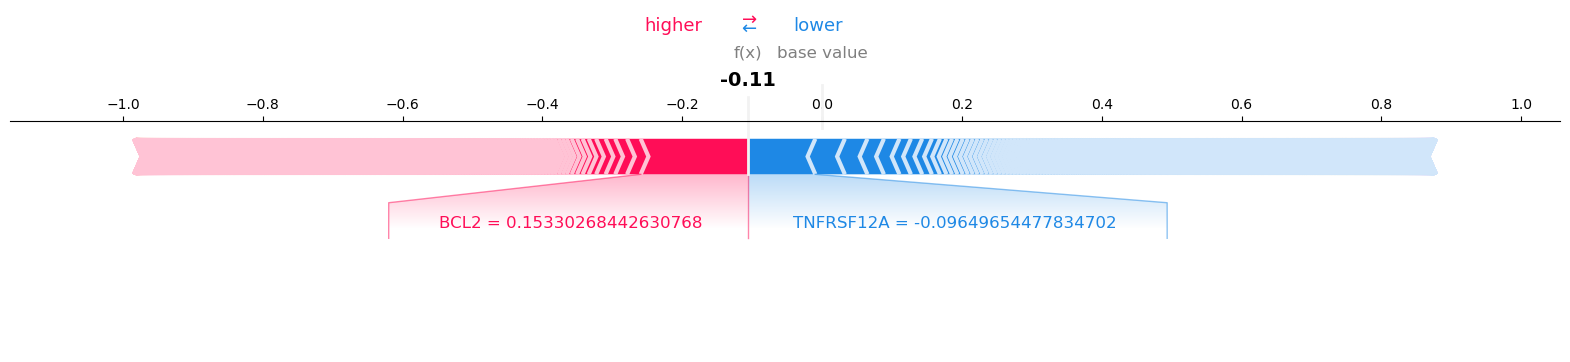

In [28]:
import shap

# Select an index from the shap_df dataframe
sample_index = shap_df.index[0]  # Using the first index as an example

# Get the SHAP values for the selected sample
shap_values = shap_df.loc[sample_index]

# Create an Explanation object
explanation = shap.Explanation(values=shap_values.values,
                               base_values=np.zeros(len(shap_values)),
                               data=shap_values.values,
                               feature_names=shap_values.index.tolist())

# Visualize the SHAP values using a force plot
shap.plots.force(explanation, matplotlib=True)


We can also compute the absolute average shap importance

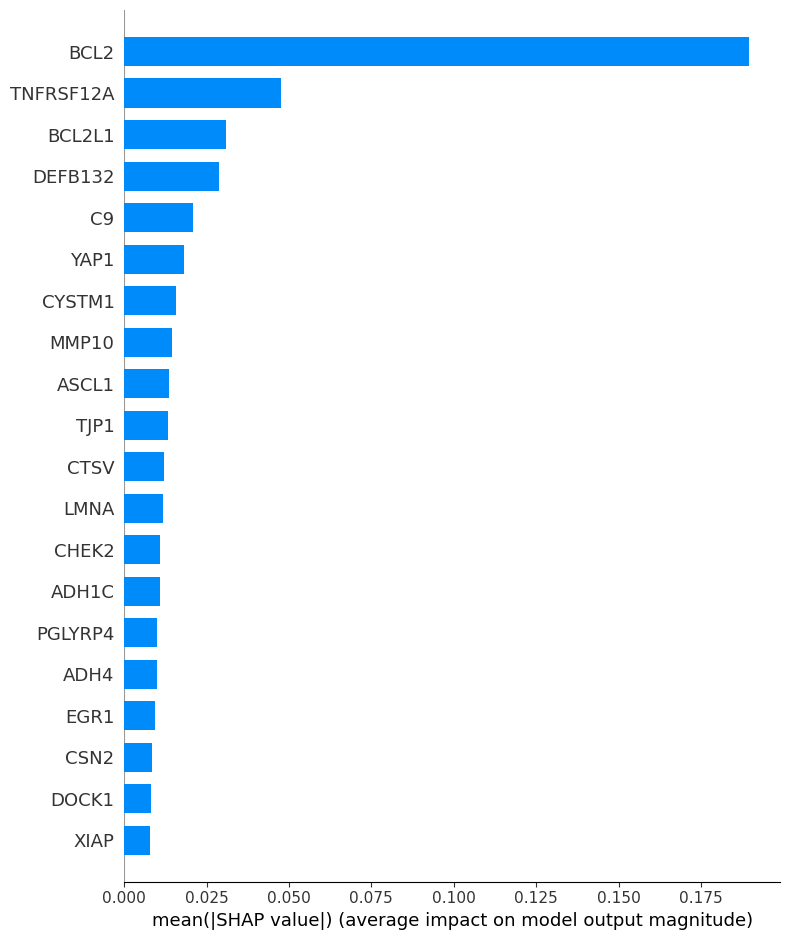

In [29]:
import matplotlib.pyplot as plt

# Calculate mean absolute SHAP values for overall feature importance
mean_abs_shap = np.abs(shap_df).mean()

# Sort features by importance
feature_importance = mean_abs_shap.sort_values(ascending=False)

# Plot feature importance
shap.summary_plot(shap_df.values, shap_df.columns, plot_type="bar", max_display=20)